# Introduction into correlation expansion


As example we will investigate a system consisting of 2 spins and 2 cavities in a linear arangement.

```
       /         \     g2           g1           g2     /         \
----> (  cavity1  )   ---- [spin1] ---- [spin2] ----   (  cavity2  )
  η    \         /                                      \         /        
            (                 (           (                  (
         κ1  )              γ  )        γ  )              κ2  )
            (                 (           (                  (
            v                 v           v                  v
     
```



 

### Simulate the system in the usual way

In [1]:
using PyPlot
using QuantumOptics
const ce = correlationexpansion;

Define parameters

In [2]:
Ncutoff = 3

ωa = 0.1 # Spin transition frequency
ωc = 0.2 # Cavity frequency
η = 0.8 # Pumping strength
g1 = 1. # Coupling spin-spin
g2 = 1. # Coupling spin-cavity
γ = 0.1 # Decay rate spin
κ1 = 3. # Decay rate left cavity
κ2 = 0.6 # Decay rate left cavity

Γ = [κ1, γ, γ, κ2]

T = [0:0.01:10;];

Define bases and create common operators

In [3]:
spinbasis = SpinBasis(1//2)
fockbasis = FockBasis(Ncutoff)
basis = fockbasis ⊗ spinbasis ⊗ spinbasis ⊗ fockbasis

sz = sigmaz(spinbasis)
sm = sigmam(spinbasis)
sp = sigmap(spinbasis)

a = destroy(fockbasis)
at = create(fockbasis)
n = at*a;

Create Hamiltonian and Jump operators

In [4]:
h1 = embed(basis, 1, ωc*n + η*(a + at)) # Left Cavity
h2 = embed(basis, 2, ωa*sz) # Left Spin
h3 = embed(basis, 3, ωa*sz) # Right Spin
h4 = embed(basis, 4, ωc*n) # Right Cavity
h12 = g2*embed(basis, [1,2], [a,sp]) + g2*embed(basis, [1,2], [at,sm]) # Left Cavity - Left Spin
h23 = g1*embed(basis, [2,3], [sm,sp]) + g1*embed(basis, [2,3], [sp,sm]) # Left Spin - Middle Spin
h34 = g2*embed(basis, [3,4], [sm,at]) + g2*embed(basis, [3,4], [sp,a]) # Right Spin - Right Cavity;

Hsparse = h1 + h2 + h3 + h4 + h12 + h23 + h34

j1 = embed(basis, 1, a) # Left Cavity
j2 = embed(basis, 2, sm)  # Left Spin
j3 = embed(basis, 3, sm) # Right Spin
j4 = embed(basis, 4, a) # Right Cavity

Jsparse = [j1, j2, j3, j4];

Perform time evolution

In [5]:
Ψspin = spindown(spinbasis)
Ψfock = fockstate(fockbasis, 0)
Ψ₀ = Ψfock ⊗ Ψspin ⊗ Ψspin ⊗ Ψfock

@time tout, ρ_t = timeevolution.master(T, Ψ₀, Hsparse, Jsparse; Gamma=Γ);

  1.149801 seconds (841.63 k allocations: 98.668 MB, 3.28% gc time)


Define helper functions to easily calculate photonnumbers and spin excitations

In [6]:
photons1(ρ_t) = [real(expect(n, ptrace(ρ, [2,3,4]))) for ρ in ρ_t]
photons2(ρ_t) = [real(expect(n, ptrace(ρ, [1,2,3]))) for ρ in ρ_t]
excitations1(ρ_t) = [real(expect(sz, ptrace(ρ, [1,3,4]))) for ρ in ρ_t]
excitations2(ρ_t) = [real(expect(sz, ptrace(ρ, [1,2,4]))) for ρ in ρ_t];

Plot time evolution of photonnumbers and excitations

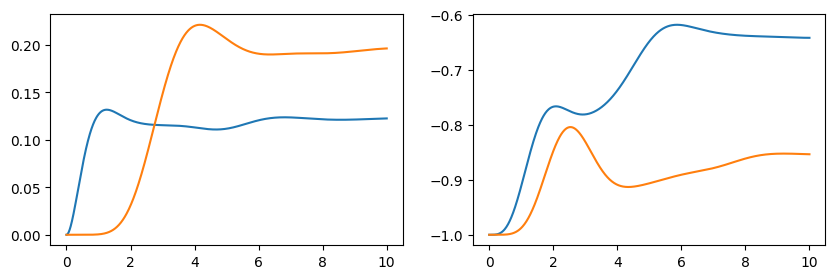

In [7]:
figure(figsize=[10,3])
subplot(1,2,1)
plot(tout, photons1(ρ_t))
plot(tout, photons2(ρ_t))

subplot(1,2,2)
plot(tout, excitations1(ρ_t))
plot(tout, excitations2(ρ_t));

### Analyze correlations occuring in this system

We can use the correlation function to calculate the pairwise correlations specified by the given indices.

In [8]:
C(ρ_t, indices) = [tracenorm_general(ce.correlation(ρ, indices)) for ρ in ρ_t];

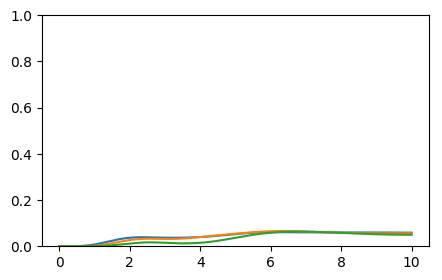

In [9]:
figure(figsize=[5,3])
ylim(0, 1)

plot(tout, C(ρ_t, [1,2]))
plot(tout, C(ρ_t, [1,3]))
plot(tout, C(ρ_t, [1,4]));

When calculating several higher order correlations it is more efficient to calculate them all at once by creating a CorrelationExpansion using the approximate function. Which correlations are included is specified by the indices generated by the masks function. In this case it returns all triple correlations for 4 subsystems.

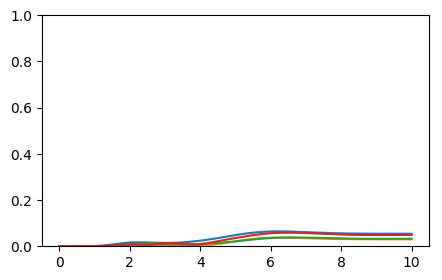

In [10]:
ρce_t = [ce.approximate(ρ, ce.masks(4, 3)) for ρ in ρ_t];

figure(figsize=[5,3])
ylim(0, 1)

plot(tout, C(ρce_t, [1,2,3]))
plot(tout, C(ρce_t, [1,2,4]))
plot(tout, C(ρce_t, [1,3,4]))
plot(tout, C(ρce_t, [2,3,4]));

## Simulate the system using only certain correlations

In this case we don't want to create operators living in the total Hilbert space. Instead we specify them as sum of lazy tensors to avoid the exponential explosion of their size. The syntax is extremely similar to the usual case and mostly consists in replacing the embed function with a LazyTensor.

In [11]:
h1 = LazyTensor(basis, 1, ωc*n + η*(a + at)) # Left Cavity
h2 = LazyTensor(basis, 2, ωa*sz) # Left Spin
h3 = LazyTensor(basis, 3, ωa*sz) # Right Spin
h4 = LazyTensor(basis, 4, ωc*n) # Right Cavity
h12 = g2*LazyTensor(basis, [1,2], [a,sp])
h21 = g2*LazyTensor(basis, [1,2], [at,sm]) # Left Cavity - Left Spin
h23 = g1*LazyTensor(basis, [2,3], [sm,sp])
h32 = g1*LazyTensor(basis, [2,3], [sp,sm]) # Left Spin - Middle Spin
h34 = g2*LazyTensor(basis, [3,4], [sm,at])
h43 = g2*LazyTensor(basis, [3,4], [sp,a]) # Right Spin - Right Cavity

H = LazySum(h1, h2, h3, h4, h12, h21, h23, h32, h34, h43)

j1 = LazyTensor(basis, 1, a) # Left Cavity
j2 = LazyTensor(basis, 2, sm) # Left Spin
j3 = LazyTensor(basis, 3, sm) # Right Spin
j4 = LazyTensor(basis, 4, a) # Right Cavity

J = [j1, j2, j3, j4];

It can easily be verified that these are indeed the same as the previously defined sparse operators.

In [12]:
@assert sparse(H) == Hsparse
for i in 1:4
    @assert sparse(J[i]) == Jsparse[i]
end

Now we have to choose which correlations we want to include. A correlation is specified by a vector containing the indices of the involved subsystems. The mask function simplifies to produce all correlations of a certain order.

In [13]:
S2 = ce.masks(4,2) # All pairwise correlations
S3 = ce.masks(4,3) # All triple correlations

S2_ = [[1,2], [1,3], [2,3], [2,4], [3,4]] # All pairwise correlations but the cavity-cavity correlation
S3_ = [[1,2,3], [2,3,4]] # All triple correlations not containing both cavities;

With these correlations we can create according CorrelationExpansion operators as initial condition. Again we avoid calculating a dense operator living in the total Hilbert space.

In [14]:
Ψspin = spindown(spinbasis)
Ψfock = fockstate(fockbasis, 0)
ρspin = Ψspin ⊗ dagger(Ψspin)
ρfock = Ψfock ⊗ dagger(Ψfock)

operators = [ρfock, ρspin, ρspin, ρfock]

ρce_order1 = ce.CorrelationExpansion(operators) # No correlations
ρce_order2 = ce.CorrelationExpansion(operators, S2)
ρce_select2 = ce.CorrelationExpansion(operators, S2_)
ρce_order3 = ce.CorrelationExpansion(operators, S2 ∪ S3)
ρce_select3 = ce.CorrelationExpansion(operators, S2_ ∪ S3_);

The syntax to perform the time evolution is completely equivalent to the usual case.

In [15]:
@time tout, ρce_order1_t = ce.master(T, ρce_order1, H, J; Gamma=Γ)
@time tout, ρce_order2_t = ce.master(T, ρce_order2, H, J; Gamma=Γ)
@time tout, ρce_select2_t = ce.master(T, ρce_select2, H, J; Gamma=Γ)
@time tout, ρce_order3_t = ce.master(T, ρce_order3, H, J; Gamma=Γ)
@time tout, ρce_select3_t = ce.master(T, ρce_select3, H, J; Gamma=Γ);

  1.769476 seconds (1.50 M allocations: 68.557 MB, 1.18% gc time)
  2.582368 seconds (25.84 M allocations: 1.933 GB, 12.70% gc time)
  1.812655 seconds (20.59 M allocations: 1.376 GB, 10.49% gc time)
 11.536023 seconds (75.07 M allocations: 10.483 GB, 11.46% gc time)
  4.947075 seconds (43.21 M allocations: 3.643 GB, 11.29% gc time)


We can now compare the different approaches

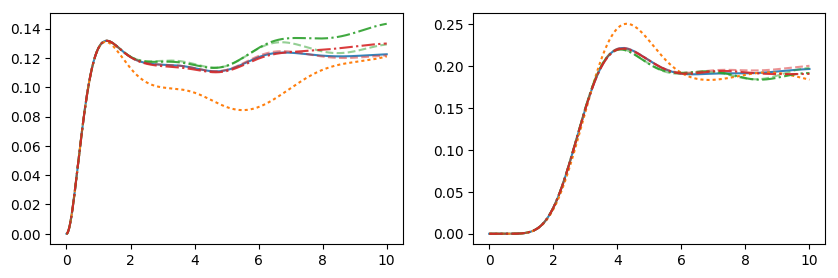

In [16]:
figure(figsize=[10,3])
subplot(1,2,1)
plot(tout, photons1(ρ_t), alpha=0.9)
plot(tout, photons1(ρce_order1_t), ":")
plot(tout, photons1(ρce_order2_t), "C2--", alpha=0.5)
plot(tout, photons1(ρce_select2_t), "C2-.", alpha=0.9)
plot(tout, photons1(ρce_order3_t), "C3--", alpha=0.5)
plot(tout, photons1(ρce_select3_t), "C3-.", alpha=0.9)


subplot(1,2,2)
plot(tout, photons2(ρ_t), alpha=0.9)
plot(tout, photons2(ρce_order1_t), ":")
plot(tout, photons2(ρce_order2_t), "C2--", alpha=0.5)
plot(tout, photons2(ρce_select2_t), "C2-.", alpha=0.9)
plot(tout, photons2(ρce_order3_t), "C3--", alpha=0.5)
plot(tout, photons2(ρce_select3_t), "C3-.", alpha=0.9);

## Simulate the system for high photon numbers

For the previous case where the cutoff of the cavity photons was chosen extremely small the correlation expansion approach was much slower. However, already

In [17]:
photons1_(ρ_t) = [real(expect(number(ρ_t[1].basis_l.bases[1]), ptrace(ρ, [2,3,4]))) for ρ in ρ_t]
photons2_(ρ_t) = [real(expect(number(ρ_t[1].basis_l.bases[4]), ptrace(ρ, [1,2,3]))) for ρ in ρ_t];

In [18]:
function create_operators(params)
    Ncutoff = params["Ncutoff"]
    ωc = params["ωc"]
    ωa = params["ωa"]
    η = params["η"]
    g1 = params["g1"]
    g2 = params["g2"]
    γ = params["γ"]
    κ1 = params["κ1"]
    κ2 = params["κ2"]
    Γ = [κ1, γ, γ, κ2]
    
    spinbasis = SpinBasis(1//2)
    fockbasis = FockBasis(Ncutoff)
    basis = fockbasis ⊗ spinbasis ⊗ spinbasis ⊗ fockbasis

    sz = sigmaz(spinbasis)
    sm = sigmam(spinbasis)
    sp = sigmap(spinbasis)

    a = destroy(fockbasis)
    at = create(fockbasis)
    n = at*a;
    
    H = LazySum(
            LazyTensor(basis, 1, ωc*n + η*(a + at)), # Left Cavity
            LazyTensor(basis, 2, ωa*sz), # Left Spin
            LazyTensor(basis, 3, ωa*sz), # Right Spin
            LazyTensor(basis, 4, ωc*n), # Right Cavity
            g2*LazyTensor(basis, [1,2], [a,sp]), g2*LazyTensor(basis, [1,2], [at,sm]), # Left Cavity - Left Spin
            g1*LazyTensor(basis, [2,3], [sm,sp]), g1*LazyTensor(basis, [2,3], [sp,sm]), # Left Spin - Middle Spin
            g2*LazyTensor(basis, [3,4], [sm,at]), g2*LazyTensor(basis, [3,4], [sp,a]), # Right Spin - Right Cavity
    )

    J = LazyTensor[
        LazyTensor(basis, 1, a), # Left Cavity
        LazyTensor(basis, 2, sm), # Left Spin
        LazyTensor(basis, 3, sm), # Right Spin
        LazyTensor(basis, 4, a) # Right Cavity
    ]
    H, Γ, J
end

function create_initialstate(S, params)
    spinbasis = SpinBasis(1//2)
    fockbasis = FockBasis(params["Ncutoff"])
    basis = fockbasis ⊗ spinbasis ⊗ spinbasis ⊗ fockbasis
    
    Ψfock = fockstate(fockbasis, 0)
    ρfock = Ψfock ⊗ dagger(Ψfock)
    Ψspin = spindown(spinbasis)
    ρspin = Ψspin ⊗ dagger(Ψspin)
    ce.CorrelationExpansion([ρfock, ρspin, ρspin, ρfock], S)
end

function ce_timeevolution(S, params)
    H, Γ, J = create_operators(params)
    ρce = create_initialstate(S, params)
    ce.master(params["T"], ρce, H, J; Gamma=Γ)
end;

function sparse_timeevolution(params)
    H, Γ, J = create_operators(params)
    ρ = full(create_initialstate([], params))
    timeevolution.master(params["T"], ρ, sparse(H), [sparse(j) for j in J]; Gamma=Γ)
end;

In [19]:
P = Dict(
    "Ncutoff" => 3,
    "ωa" => 0.1, # Spin transition frequency
    "ωc" => 0.2, # Cavity frequency;
    "η" => 1., # Pumping strength
    "g1" => 0.5, # Coupling spin-spin
    "g2" => 0.5, # Coupling spin-cavity
    "γ" => 0.3, # Decay rate spin
    "κ1" => 1., # Decay rate left cavity
    "κ2" => 0.6, # Decay rate left cavity
    "T" => [0:0.01:10;]
);

In [20]:
P["Ncutoff"] = 3

@time tout, ρ_t = sparse_timeevolution(P);
@time tout, ρce_order1_t = ce_timeevolution([], P);
@time tout, ρce_order2_t = ce_timeevolution(S2, P);
@time tout, ρce_select2_t = ce_timeevolution(S2_, P);
@time tout, ρce_select3_t = ce_timeevolution(S2_ ∪ S3_, P);

  0.434806 seconds (220.93 k allocations: 73.422 MB, 4.15% gc time)
  0.113378 seconds (371.42 k allocations: 21.430 MB, 20.73% gc time)
  2.499886 seconds (24.08 M allocations: 1.804 GB, 15.94% gc time)
  1.721786 seconds (18.98 M allocations: 1.274 GB, 12.67% gc time)
  4.901590 seconds (39.82 M allocations: 3.359 GB, 14.57% gc time)


In [21]:
P["Ncutoff"] = 8

@time tout, ρ_t = sparse_timeevolution(P);
@time tout, ρce_order1_t = ce_timeevolution([], P);
@time tout, ρce_order2_t = ce_timeevolution(S2, P);
@time tout, ρce_select2_t = ce_timeevolution(S2_, P);
@time tout, ρce_select3_t = ce_timeevolution(S2_ ∪ S3_, P);

  6.856357 seconds (48.02 k allocations: 1.589 GB, 35.05% gc time)
  0.152071 seconds (377.24 k allocations: 26.949 MB, 56.76% gc time)
  6.549433 seconds (24.57 M allocations: 8.337 GB, 17.36% gc time)
  2.605871 seconds (20.28 M allocations: 2.211 GB, 15.68% gc time)
  8.950093 seconds (44.13 M allocations: 8.500 GB, 16.48% gc time)


In [22]:
P["Ncutoff"] = 30

@time tout, ρce_order1_t = ce_timeevolution([], P);
# @time tout, ρce_order2_t = ce_timeevolution(S2, P);
@time tout, ρce_select2_t = ce_timeevolution(S2_, P);
@time tout, ρce_select3_t = ce_timeevolution(S2_ ∪ S3_, P);

  0.307763 seconds (749.91 k allocations: 117.981 MB, 5.79% gc time)
 22.879711 seconds (44.32 M allocations: 29.226 GB, 16.33% gc time)
107.174850 seconds (94.73 M allocations: 155.481 GB, 18.92% gc time)


In [ ]:
figure(figsize=[10,3])
subplot(1,2,1)
plot(tout, photons1_(ρ_t), alpha=0.9)
plot(tout, photons1_(ρce_order1_t), ":")
plot(tout, photons1_(ρce_order2_t), "C2--", alpha=0.5)
plot(tout, photons1_(ρce_select2_t), "C2-.", alpha=0.9)
# plot(tout, photons1(ρce_order3_t), "C3--", alpha=0.5)
plot(tout, photons1_(ρce_select3_t), "C3-.", alpha=0.9)


subplot(1,2,2)
plot(tout, photons2_(ρ_t), alpha=0.9)
plot(tout, photons2_(ρce_order1_t), ":")
plot(tout, photons2_(ρce_order2_t), "C2--", alpha=0.5)
plot(tout, photons2_(ρce_select2_t), "C2-.", alpha=0.9)
# plot(tout, photons2(ρce_order3_t), "C3--", alpha=0.5)
plot(tout, photons2_(ρce_select3_t), "C3-.", alpha=0.9);